In [56]:
import os
import json
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from pycocotools import mask
import skimage.measure as measure
from scipy import stats
from tqdm import tqdm

In [52]:
# output.csv 읽기
submission1 = pd.read_csv('./DH_output.csv', index_col=None)
submission2 = pd.read_csv('./HJ_output.csv', index_col=None)
submission3 = pd.read_csv('./SY_output.csv', index_col=None)
submission4 = pd.read_csv('./WJ_output.csv', index_col=None)

subs = [submission1, submission2, submission3, submission4]

# 데이터 경로
dataset_path = '/opt/ml/level2_semanticsegmentation_cv-level2-cv-15/data'


# 클래스
classes = ['Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal',
            'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

# 클래스 색깔
palette = [
    [0, 0, 0], [192, 0, 128], [0, 128, 192], [0, 128, 64], [128, 0, 0], [64, 0, 128],
    [64, 0, 192], [192, 128, 64], [192, 192, 128], [64, 64, 128], [128, 0, 192]
]


In [53]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, rgb in enumerate(palette):
        colormap[inex] = [rgb[0], rgb[1], rgb[2]]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

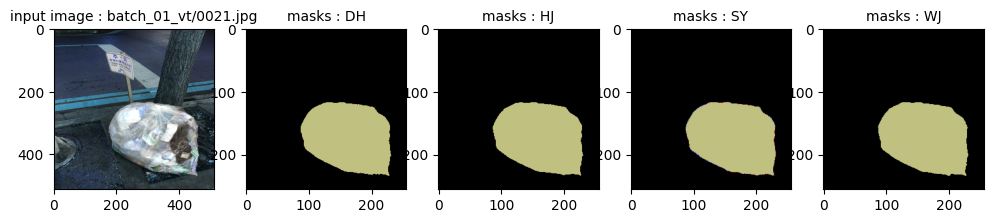

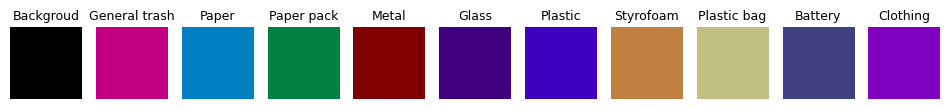

In [54]:
# 각 csv 파일 inference 결과 시각화

IMAGE_NUM = 0

masks = []

for sub in subs:
    dmask = np.fromstring(sub['PredictionString'][IMAGE_NUM], dtype=int, sep=' ').reshape(256, -1)
    masks.append(dmask)

    
images = cv2.imread(os.path.join(dataset_path, subs[0]['image_id'][IMAGE_NUM]))


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

ax1.imshow(images)
ax1.grid(False)
ax1.set_title("input image : {}".format(subs[0]['image_id'][IMAGE_NUM]), fontsize = 10)

ax2.imshow(label_to_color_image(masks[0]))
ax2.grid(False)
ax2.set_title("masks : {}".format("DH"), fontsize = 10)

ax3.imshow(label_to_color_image(masks[1]))
ax3.grid(False)
ax3.set_title("masks : {}".format("HJ"), fontsize = 10)

ax4.imshow(label_to_color_image(masks[2]))
ax4.grid(False)
ax4.set_title("masks : {}".format("SY"), fontsize = 10)

ax5.imshow(label_to_color_image(masks[3]))
ax5.grid(False)
ax5.set_title("masks : {}".format("WJ"), fontsize = 10)

plt.show()


plt.figure(figsize=(12,12))
ind = 0
for i in range(11):
    plt.subplot(1, 11, i+1)
    plt.imshow([[(palette[i][0]/255, palette[i][1]/255, palette[i][2]/255)]])
    plt.title(classes[i], fontsize=9)
    plt.axis('off')
    ind += 1
plt.show()

In [57]:
# Psuedo Labeling
print("Start Pseudo Labeling...")

start_id = 0
start_anno_id = 0
annotations = []

for ind in tqdm(range(819)):
    upmasks = []
    m = nn.Upsample(scale_factor=2, mode='nearest')  # (512, 512) 로 만들어주기 위한 upsampling
    
    pseudo_mask = np.zeros((512, 512), dtype=np.int32)
    
    # (512, 512) 를 4개 쌓아서 (4, 512, 512) 로 만든후 최빈값 뽑아내기
    for i in range(len(subs)):
        dmask = np.fromstring(subs[i]['PredictionString'][ind], dtype=int, sep=' ').reshape(256, -1)
        upmask = m(torch.Tensor(dmask).view(1, 1, 256, 256)).int().numpy().reshape(512,512)
        
        upmasks.append(upmask)
    
    upmasks = np.stack(upmasks)
    m = stats.mode(upmasks)
    pseudo_mask = m[0].squeeze()
    
    # 만들어진 mask의 카테고리 값 구하기
    category = np.unique(pseudo_mask)
    
    for cls in list(category):
        # background 클래스를 제외하고 각각 class 별로 binary mask 를 구해서 annoataion 만들기
        if int(cls) == 0:
            continue
        
        binary_mask = np.zeros((512, 512), dtype=np.uint8)
        for x in range(512):
            for y in range(512):
                if pseudo_mask[x][y] == cls:
                    binary_mask[x][y] = 1
        
        
        # 코드 참조 : https://github.com/cocodataset/cocoapi/issues/131
        fortran_ground_truth_binary_mask = np.asfortranarray(binary_mask)
        encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
        ground_truth_area = mask.area(encoded_ground_truth)
        ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
        contours = measure.find_contours(binary_mask, 0.5)


        annotation = {
                "segmentation": [],
                "area": ground_truth_area.tolist(),
                "iscrowd": 0,
                "image_id": start_id,
                "bbox": ground_truth_bounding_box.tolist(),
                "category_id": int(cls),
                "id": start_anno_id
            }

        for contour in contours:
            contour = np.flip(contour, axis=1)
            segmentation = contour.ravel().tolist()
            annotation["segmentation"].append(segmentation)

        start_anno_id += 1
        #if len(annotation['segmentation'][0]) != 4:
        annotations.append(annotation)
        
    start_id += 1
print("Done")

  0%|          | 0/819 [00:00<?, ?it/s]

Start Pseudo Labeling...


100%|██████████| 819/819 [1:43:46<00:00,  7.60s/it]

Done


In [58]:
# test json 불러오기
test_json_path = "/opt/ml/level2_semanticsegmentation_cv-level2-cv-15/data/test.json"

# 결과물이 저장될 root와 이름 설정
output_root = "/opt/ml/level2_semanticsegmentation_cv-level2-cv-15/data"
output_json_name = "pseudo_test"
output_path = os.path.join(output_root,output_json_name + ".json")

with open(test_json_path) as f:
    test_json = json.load(f)


test_json['annotations'] += annotations

with open(output_path, 'w') as f:
    json.dump(test_json, f)

print(f'{len(annotations)}개의 annotations이 추가되었습니다.\n')

3278개의 annotations이 추가되었습니다.

